In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!pip install pytorch_lightning

In [12]:
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torchvision.models as models
from torchvision import transforms as T
import torch
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import random
from sklearn.model_selection import train_test_split

In [4]:
!ls -al ./*.zip
data_zip_file = './dogs-vs-cats.zip'

-rw-r--r-- 1 tqlong cs 851576689 Oct 30 16:20 ./dogs-vs-cats.zip


In [5]:
data_zip = zipfile.ZipFile(data_zip_file)
file_names = data_zip.namelist()
len(file_names)

3

In [6]:
train_zip = zipfile.ZipFile(data_zip.open('train.zip'))
train_file_names = [fname for fname in train_zip.namelist() if 'dog' in fname or 'cat' in fname]
len(train_file_names)

25000

0 train/cat.0.jpg


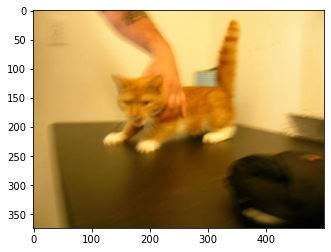

In [7]:
for i, fname in enumerate(train_file_names):
  print(i, fname)
  img = Image.open(train_zip.open(fname))
  plt.imshow(img)
  break
  if i >= 10: break

In [42]:
def prepare_data():
    train_zip = zipfile.ZipFile('train.zip')
    file_names = [fname for fname in train_zip.namelist() if 'dog' in fname or 'cat' in fname]
    print('Loading images metadata...')
    images = [Image.open(train_zip.open(fname)) for fname in file_names]
    print('Reading pixels...')
    for i, img in enumerate(images):
        img.load()
        if i % 1000 == 0:
            print(i)
    [img.load() for img in images]
    print('Done', len(images))
    targets = [1 if 'dog' in fname else 0 for fname in file_names]

    return images, targets

Epoch 0:   3%|▏        | 41/1563 [10:55<6:36:08, 15.62s/it, loss=0.561, v_num=4]


In [41]:
class MyNet(pl.LightningModule):
  def __init__(self, n_classes=2):
    super().__init__()
    self.features = models.resnet18(pretrained=True)
    self.features.fc = torch.nn.Linear(512, n_classes) # change the classification head from 1000 classes to 2 classes (dog/cat)

  def forward(self, x):
    out = self.features(x)
    out = F.log_softmax(out, dim=1)
    return out

  def training_step(self, batch, batch_idx):
    x, y = batch
    logits = self(x)
    loss = F.nll_loss(logits, y)
    self.log("train_loss", loss)
    return loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    logits = self(x)
    loss = F.nll_loss(logits, y)
    _, preds = torch.max(logits, dim=1)
    self.log("val_loss", loss)
    self.log("val_acc", (preds==y).sum()/len(y))
    return preds

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=1e-3)

class MyDataset(Dataset):
  def __init__(self, images, targets, transform=None):
    super().__init__()
    self.images = images
    self.targets = targets
    self.transform = transform

  def __len__(self):
    return len(self.targets)

  def __getitem__(self, idx):
    img = self.images[idx]
    y = self.targets[idx]
    if self.transform is not None:
      img = self.transform(img)
    
    return img, y

class MyDataModule(pl.LightningDataModule):
  def __init__(self, images, targets, test_size=0.3):
    super().__init__()
    self.images = images
    self.targets = targets
    self.test_size = test_size

  def prepare_data(self):
    # called only on 1 GPU
    self.train_images, self.val_images, self.train_targets, self.val_targets = train_test_split(self.images, self.targets, test_size=self.test_size)

  def _split(self, file_names):
    random.shuffle(file_names)
    n = len(file_names)
    return file_names[:int(n*self.test_size)], file_names[int(n*self.test_size):]

  def setup(self, stage=None):
    train_transform = T.Compose([
       T.Resize(256), T.RandomHorizontalFlip(), T.RandomRotation(10),
       T.RandomCrop(224), T.ToTensor(),
       T.Normalize(mean=[0.485, 0.456, 0.406],
                   std=[0.229, 0.224, 0.225])
    ])
    val_transform = T.Compose([
       T.Resize(256), T.CenterCrop(224), T.ToTensor(),
       T.Normalize(mean=[0.485, 0.456, 0.406],
                   std=[0.229, 0.224, 0.225])
    ])
    self.train = MyDataset(self.train_images, self.train_targets, transform=train_transform)
    self.val = MyDataset(self.val_images, self.val_targets, transform=val_transform)

  def train_dataloader(self):
      return DataLoader(self.train, batch_size=16)

  def val_dataloader(self):
      return DataLoader(self.val, batch_size=16)

def main():
  net = MyNet()
  # net = MyNet().cuda()
  # x = torch.zeros(1,3,224,224).cuda()
  # out = net(x)
  # print(out.shape)

  # dataset = MyDataset(images, targets)
  # print('data', len(dataset))
  # x, y = dataset[0]
  # plt.imshow(x)
  # print('x.shape', x.size)

  images, targets = prepare_data()
  dm = MyDataModule(images, targets)
  # dm.prepare_data()
  # dm.setup()
  # train_loader = dm.train_dataloader()
  # x, y = iter(train_loader).next()
  # print(x.shape, y.shape)

  trainer = pl.Trainer(gpus=1, max_epochs=1)
  trainer.fit(net, dm)
  return net

net = main()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type   | Params
------------------------------------
0 | features | ResNet | 11.2 M
------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Epoch 0:  70%|██████▎  | 1094/1563 [01:41<00:43, 10.77it/s, loss=0.158, v_num=6]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|█████████| 1563/1563 [02:10<00:00, 12.01it/s, loss=0.158, v_num=6]


In [25]:
xtr,xte,ytr,yte = train_test_split(images, targets, test_size=0.3)

In [33]:
ytr[-1]

1